In [31]:
#import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pycutest
import warnings
import scipy
from ECNoise import ECNoise
#ignore warnings from pycutest (does not affect actual calculations)
warnings.simplefilter('ignore')

In [32]:
'''
temp_arr = scipy.optimize.fmin_bfgs(lambda x: fobj(x, iterRange), firstX, fprime=lambda x: gobj(x, iterRange), maxiter=iterRange, full_output=True, retall=True, disp=False)
    fcall = temp_arr[4]
    gcall = temp_arr[5]
    f_class_error = np.apply_along_axis(trueF, 1, temp_arr[7])
    g_class_error = np.apply_along_axis(np.linalg.norm, 1, (np.apply_along_axis(trueG, 1, temp_arr[7])))
'''
def BFGS(func,firstX, grad,max_iter):
    xkArr = []
    gradArr = []
    grad_calls = []
    func_calls = []
    totGradCall = 0
    totFuncCall = 0
    
    iter = 0
    dim = firstX.shape[0]
    xk = firstX
    identity = np.identity(dim)
    H = identity
    cur_grad = grad(xk)
    totGradCall += 1  # Initial gradient call

    # Append initial xk to xkArr
    xkArr.append(xk.copy())

    while np.linalg.norm(cur_grad) > 0:
        pk = -np.dot(H, cur_grad)

        alpha, fc, gc, _, _, _ = scipy.optimize.line_search(func, grad, xk, pk, gfk=cur_grad)
        if alpha is None:
            alpha = 1
        totGradCall += gc
        totFuncCall += fc

        sk = alpha * pk
        yk = grad(xk + alpha * pk) - cur_grad
        totGradCall += 1

        if iter == 0:
            H = (np.dot(yk, sk) / np.dot(yk, yk)) * identity

        rho = 1. / np.dot(sk, yk)
        mat = identity - rho * np.outer(sk, yk)
        H = np.matmul(np.matmul(mat, H), mat.transpose()) + rho * np.outer(sk, sk)

        iter += 1
        if iter > max_iter:
            break
        
        xk = xk + alpha * pk
        cur_grad = grad(xk)
        totGradCall += 1
        
        # Append the current xk to xkArr
        xkArr.append(xk.copy())
        
        grad_calls = np.append(grad_calls, totGradCall)
        func_calls = np.append(func_calls, totFuncCall)
    return func_calls, grad_calls, xkArr

# Example usage with placeholders for `trueF` and `trueG`:
# BFGS(optProb, func, grad, max_iter, firstX, dim)


# Example usage with placeholders for `trueF` and `trueG`:
# BFGS(optProb, func, grad, max_iter, firstX, dim, trueF, trueG)


In [33]:
def sp_bfgs(fobj, gobj, fTrue, gTrue, x0, max_iter, total_runs=30, epsilon_g=np.sqrt(300)*0.001, epsilon_f=0.001, alpha_0=1, c_1=1e-4, tau=0.5, noise_tol=0, max_backtracks=45, termination_eps=0):
    np.random.seed(69)
    
    # Allocate storage
    trueObj = []
    errorObj = []
    errorGrad = []
    trueGrad = []
    func_calls_per_iter = []
    grad_calls_per_iter = []
    
    # Optimization setup
    x_0 = x0
    dim = x_0.shape[0]
    H_0 = np.identity(dim)
    
    # Counters and initial values
    curv_fail_count = 0
    line_search_fail_count = 0
    obj_fun_eval_count = 0
    grad_eval_count = 0
    best_true_obj_val = np.inf
    
    # SP-BFGS Loop
    x = x_0
    H = H_0
    f_old = np.inf
    f_old_true = np.inf
    g_old = np.zeros(dim)
    iter_count = 0
    
    while iter_count < max_iter:
        iter_count += 1
        alpha = alpha_0
        
        if obj_fun_eval_count == 0:
            f_old = fobj(x)
            f_old_true = fTrue(x)
            g_old = gobj(x)
            obj_fun_eval_count += 1
            grad_eval_count += 1

        x_old = x
        p = -np.dot(H, g_old)
        x = x_old + alpha * p

        f_new = fobj(x)
        f_new_true = fTrue(x)
        g_new = gobj(x)
        g_new_true = gTrue(x)
        obj_fun_eval_count += 1
        grad_eval_count += 1

        # Append the objective values and counts to the arrays
        trueObj.append(f_new_true)
        errorObj.append(f_new)
        errorGrad.append(np.linalg.norm(g_new))
        trueGrad.append(np.linalg.norm(g_new_true))
        func_calls_per_iter.append(obj_fun_eval_count)
        grad_calls_per_iter.append(grad_eval_count)

        # Backtracking line search
        line_search_fail = 0
        backtracks = 0
        while f_new > f_old + c_1 * alpha * np.dot(g_old, p) + 2 * noise_tol and backtracks < 20:
            line_search_fail += 1
            backtracks += 1
            if line_search_fail > max_backtracks:
                alpha = 0
            else:
                alpha = tau * alpha
            x = x_old + alpha * p
            f_new = fobj(x)
            f_new_true = fTrue(x)
            g_new = gobj(x)
            obj_fun_eval_count += 1
            grad_eval_count += 1

        line_search_fail_count += line_search_fail

        # Calculate secant condition parameters
        s_k = x - x_old
        y_k = g_new - g_old
        y_k_dot_s_k = np.dot(s_k, y_k)

        # Set penalty parameter
        beta_k = 1e8 * np.linalg.norm(s_k) / epsilon_g + 1e-10

        # Check penalized curvature condition
        if y_k_dot_s_k > -1 / beta_k:
            gamma_k = 1 / (y_k_dot_s_k + 1 / beta_k)
            omega_k = 1 / (y_k_dot_s_k + 2 / beta_k)

            Hy = np.dot(H, y_k)
            y_H_y = np.dot(y_k, Hy)
            D_1 = gamma_k / omega_k
            D_2 = np.dot((gamma_k - omega_k), y_H_y)

            H = (np.identity(dim) - omega_k * s_k * y_k) @ H @ (np.identity(dim) - omega_k * y_k * s_k) + omega_k * (D_1 + D_2) * s_k * s_k
        else:
            curv_fail_count += 1

        if np.linalg.norm(g_new) <= termination_eps:
            break

        f_old = f_new
        f_old_true = f_new_true
        g_old = g_new

    print('done')

    # Return the results
    return x, func_calls_per_iter, grad_calls_per_iter, trueObj, trueGrad

# Example usage:
# Define your fobj, gobj, fTrue, gTrue, and initial point x0
# optimal_value, func_calls, grad_calls, func_values, gradients = sp_bfgs(fobj, gobj, fTrue, gTrue, x0)


In [34]:
#Error tolerant BFGS implementation

def bfgs_e(optProb, func, grad, x0, max_iter, termOption = 3, bound = 0, eps_f=0., eps_g=0, tol = 1e-5 ):
    def trueF(ai):
        return optProb.obj(ai)

    def trueG(ai):
        _, grad = optProb.obj(ai, gradient=True)
        return grad
    print(eps_g)
    #initialize arrays that contain values over time
    funcArr = []
    gradArr = []
    funcCallArr = []
    gradCallArr = []
    funcCalls = 0
    gradCalls = 0
    # initialize values
    x_k = np.copy(x0)
    n = len(x_k)
    iter = 0
    alpha = 0.
    beta = 0.

    #Initializing the Hessian Guess as Identity Matrix
    H = np.identity(n)

    # track strong convexity parameter for heuristic III in paper
    mu = np.inf
    mu_hist = np.array([])

    # track average function over window
    f_avg = np.inf
    f_hist = np.array([])

    

    # get machine precision
    eps_m = np.finfo(float).eps

    #calculate initial function and gradient values
    f_k = func(x_k)
    g_k = grad(x_k)
    funcCalls += 1
    gradCalls += 1

    #calculate norm of g_k and p_k
    norm_gk = np.linalg.norm(g_k)
    norm_pk = np.copy(norm_gk)

    #compute function and gradient error bound
    eps_fk = np.copy(eps_f)
    eps_gk = np.copy(eps_g)

    #main loop
    while iter < max_iter:

        #compute initial p_k value
        p_k = -np.dot(H, g_k)
        norm_pk = np.linalg.norm(p_k)

        #perform line search
        f_old = f_k

        alpha, beta, mu_hat, f_k, g_new, eps_fk, eps_gk, armijo_flag, wolfe_flag, split_flag, fcalls, gcalls = \
            _line_search_nt_wolfe(func, grad, x_k, p_k, eps_f=eps_f, eps_g=eps_g, f_k=f_k, g_k=g_k,
                                  alpha_init=1., beta_init=1., mu=mu,
                                  c1=1e-4, c2=0.9, c3=0.5,
                                  split_iter=30, max_ls_iter=20)
        
        x_old = np.copy(x_k)

        # if Armijo condition is satisfied, perform update
        if armijo_flag:
            x_k = x_k + alpha * p_k

            # track history of function values and compute average
            f_hist = np.append(f_hist, f_k)
            if f_hist.shape[0] > 30:
                f_hist = f_hist[1:]
                f_avg = np.mean(f_hist)
        

        # if Wolfe condition is satisfied, perform BFGS update
        if wolfe_flag:
            y_k = g_new - g_k
            
            s_k = beta * p_k

        # heuristic at first iteration to capture scaling
            if iter == 0:
                
                H = np.dot(y_k, s_k) / np.dot(y_k, y_k) * np.identity(n)

            # update BFGS matrix
            rho = 1. / np.dot(s_k, y_k)
            mat = np.identity(n) - rho * np.outer(s_k, y_k)
            
            H = np.matmul(np.matmul(mat, H), mat.transpose()) + rho * np.outer(s_k, s_k)
            
            # update mu
            mu_hist = np.append(mu_hist, mu_hat)
            if mu_hist.shape[0] > 10:
                mu_hist = mu_hist[1:]
            mu = np.min(mu_hist)
        
        #iteration counter
        iter += 1
        funcCalls += fcalls
        gradCalls += gcalls
        #update arrays that contain values over time
        funcArr = np.append(funcArr,trueF(x_k))
        gradArr = np.append(gradArr,np.linalg.norm(trueG(x_k)))
        funcCallArr = np.append(funcCallArr, funcCalls)
        gradCallArr = np.append(gradCallArr, gradCalls)
        
         # set new gradient at new iterate
        # if Armijo condition holds, not split, and grad provided, sets gradient to be g_new
        if armijo_flag and not split_flag:
            g_k = g_new

        # otherwise, evaluates gradient at new point
        else:
            g_k = grad(x_k)
            eps_gk = np.copy(eps_g)
        norm_gk = np.linalg.norm(g_k)
        

            # check if desired tolerance is reached
        #if norm_gk <= tol:
            #break


        #if f_k > f_avg:
            #break

        #if norm_gk < eps_g:
            #break

        #if np.abs(f_k - f_avg) < 2 * eps_fk:
            #break
    return x_k, funcCallArr, gradCallArr, funcArr, gradArr

def _line_search_nt_wolfe(func, grad, x_k, p_k, eps_f=0., eps_g=0., f_k=None, g_k=None, alpha_init=1., beta_init=1.,
                          mu=None, c1=1e-4, c2=0.9, c3=0.5, split_iter=30, max_ls_iter=20):
    # initialize line search
    armijo_flag = False
    wolfe_flag = False
    split_flag = False
    ls_iter = 0
    funcCalls = 0
    gradCalls = 0

    # define upper and lower brackets
    upper_bracket = np.inf
    lower_bracket = 0

    # compute f_k and g_k if necessary
    if f_k is None:
        f_k = func(x_k)
        funcCalls += 1
    if g_k is None:
        g_k = grad(x_k)
        gradCalls += 1

    #compute error bounds
    eps_fk = np.copy(eps_f)
    eps_gk = np.copy(eps_g)

    # compute dot product and norm
    gtp = np.dot(g_k, p_k)
    norm_pk = np.linalg.norm(p_k)

    # initialize quantities
    g_new = np.inf
    gtp_new = np.inf

    # define both steplength and lengthening parameter
    alpha = np.copy(alpha_init)
    beta = np.copy(beta_init)

    # store best steplength, strong convexity parameter
    alpha_best = 0.
    f_best = np.inf
    eps_fbest = np.inf
    rhs = None

    # check if steplength and lengthening parameter are different
    if alpha != beta:
        split_flag = True

        # evaluate gradient
        g_new = grad(x_k + beta * p_k)
        gradCalls += 1
        gtp_new = np.dot(g_new, p_k)
    
    # compute initial step function value
    f_new = func(x_k + alpha * p_k)
    funcCalls += 1
    eps_fp = np.copy(eps_f)

    # set sufficient decrease
    if isinstance(eps_gk, np.ndarray) and eps_gk.ndim > 0 and eps_gk.shape[0] > 1:
        etp = eps_gk.dot(np.abs(p_k))
    else:
        etp = eps_gk * norm_pk


    # main loop
    while ls_iter < split_iter and not split_flag:

        # enforce sufficient decrease if condition satisfied
        if gtp < -etp:
            suff_dec = c1 * alpha * gtp

        # otherwise, enforce simple decrease
        else:
            suff_dec = 0

        # relax Armijo after 1st trial point, Heuristic I
        if ls_iter > 0:
            relax = eps_fk + eps_fp
        else:
            relax = 0

        # check Armijo condition
        if f_new > f_k + suff_dec + relax:

            # armijo failure
            armijo_flag = False

            # bisect
            upper_bracket = alpha
            alpha = (lower_bracket + alpha) / 2.0
            beta = alpha

            # evaluate function
            f_new = func(x_k + alpha * p_k)
            funcCalls += 1
            
            eps_fp = np.copy(eps_f)

        else:
            # armijo success
            armijo_flag = True

            # track best steplength
            if f_new < f_best:
                alpha_best = alpha
                f_best = f_new
                eps_fbest = eps_fp

            # evaluate gradient
            g_new = grad(x_k + beta * p_k)
            gradCalls += 1
            gtp_new = np.dot(g_new, p_k)
            eps_gp = np.copy(eps_g)

            if isinstance(eps_gk, np.ndarray) and eps_gk.ndim > 0 and eps_gk.shape[0] > 1:
                rhs = (eps_gk + eps_gp).dot(np.abs(p_k))
                
            else:
                rhs = (eps_gk + eps_gp) * norm_pk

            # check noise control condition
            if np.abs(gtp_new - gtp) < (1 + c3) * rhs:

                # split
                split_flag = True
                beta = 2 * alpha

                continue

        # check Wolfe condition
            if gtp_new < c2 * gtp:

                # wolfe failure
                wolfe_flag = False

                # bisect
                lower_bracket = alpha
                if upper_bracket == np.inf:
                    alpha = 2 * alpha
                else:
                    alpha = (upper_bracket + alpha) / 2
                beta = alpha

                # evaluate function
                f_new = func(x_k + alpha * p_k)
                funcCalls += 1
                
                eps_fp = np.copy(eps_f)

            else:
                # wolfe success
                wolfe_flag = True
        
        # iterate
        ls_iter += 1
        

        # break if both conditions satisfied
        if armijo_flag and wolfe_flag:
            break

     # change to split mode
    if not armijo_flag or not wolfe_flag or split_flag:

        split_flag = True

         # re-initialize beta if necessary
        if rhs:
            beta_hist = (1 + c3) * rhs / (mu * norm_pk ** 2)
        else:
            if isinstance(eps_gk, np.ndarray) and eps_gk.ndim > 0 and eps_gk.shape[0] > 1:
                beta_hist = 2 * (1 + c3) * eps_gk.dot(np.abs(p_k)) / (mu * norm_pk ** 2)
            else:
                beta_hist = 2 * (1 + c3) * eps_gk / (mu * norm_pk)
        beta = np.maximum(beta, beta_hist)

        # evaluate gradient
        g_new = grad(x_k + beta * p_k)
        gradCalls += 1
        gtp_new = np.dot(g_new, p_k)

        # perform backtracking and lengthening
        # use best alpha if available
        if f_best < np.inf:
            alpha = alpha_best
            f_new = f_best
            eps_fp = eps_fbest
            armijo_flag = True
        
        else:
            alpha, f_new, eps_fp, armijo_flag, bt_fcalls, bt_gcalls = \
                _backtracking(func, x_k, p_k, g_k, alpha=alpha, eps_f=eps_f, eps_g=eps_g, f_k=f_k, eps_fk=eps_fk,
                              eps_fp=eps_fp, eps_gk=eps_gk, gtp=gtp, f_new=f_new, etp=etp, norm_pk=norm_pk, c1=c1,
                              max_ls_iter=max_ls_iter)
        if not wolfe_flag:
            beta, g_new, gtp_new, eps_gp, wolfe_flag, lt_fcalls, lt_gcalls = \
                _lengthening(grad, x_k, p_k, beta=beta, eps_g=eps_g, g_k=g_k, eps_gk=eps_gk, eps_gp=eps_gp, gtp=gtp,
                             g_new=g_new, gtp_new=gtp_new, norm_pk=norm_pk, c3=c3, max_ls_iter=max_ls_iter)

    # if Armijo fails, then set to initial point
    if not armijo_flag:
        alpha = 0.0
        f_new = f_k
        eps_fp = eps_fk     

    # if Wolfe fails, set gradient to initial point
    if not wolfe_flag:
        mu = np.inf
        beta = 0.0
        g_new = g_k
        eps_gp = eps_gk

    # compute mu if beta satisfies conditions
    else:
        mu = (gtp_new - gtp) / (beta * norm_pk ** 2)       

    try:
        fcalls += bt_fcalls
    except:
        pass
    try:
        gcalls += bt_gcalls
    except:
        pass
    try:
        fcalls += lt_fcalls
    except:
        pass
    try:
        gcalls += lt_fcalls
    except:
        pass
    return alpha, beta, mu, f_new, g_new, eps_fp, eps_gp, armijo_flag, wolfe_flag, split_flag, funcCalls, gradCalls


def _backtracking(func, x_k, p_k, g_k, alpha=1., eps_f=0., eps_g=0., f_k=None, eps_fk=None, eps_fp=None,
                  eps_gk=None, gtp=None, f_new=None, etp=None, norm_pk=None, c1=1e-4, max_ls_iter=20):
    fcalls = 0
    gcalls = 0
    # initialize counter and flags
    ls_iter = 0
    armijo_flag = False

    # initialize directional derivatives and function value (if necessary)
    if gtp is None:
        gtp = np.dot(g_k, p_k)
    if f_k is None:
        f_k = func(x_k)
        fcalls += 1
    if f_new is None:
        f_new = func(x_k + alpha * p_k)
        fcalls += 1
    if norm_pk is None:
        norm_pk = np.linalg.norm(p_k)

    # initialize noise levels (if necessary)
    if eps_fk is None:
        eps_fk = np.copy(eps_f)
    if eps_fp is None:
        eps_fp = np.copy(eps_f)
    if eps_gk is None:
        eps_gk = np.copy(eps_g)

    # set sufficient decrease
    if etp is None:
        if isinstance(eps_gk, np.ndarray) and eps_gk.ndim > 0 and eps_gk.shape[0] > 1:
            etp = eps_gk.dot(np.abs(p_k))
        else:
            etp = eps_gk * norm_pk

    # enforce sufficient decrease if condition satisfied
    if gtp < -etp:
        suff_dec = c1 * alpha * gtp

    # otherwise, enforce simple decrease
    else:
        suff_dec = 0

    # relax Armijo
    relax = eps_fk + eps_fp

    # main loop
    while ls_iter < max_ls_iter:
         # check Armijo condition
        if f_new > f_k + suff_dec + relax:

            # backtrack if split
            alpha = alpha / 10.0
            f_new = func(x_k + alpha * p_k)
            fcalls += 1
            
            # reevaluate noise level
            eps_fp = np.copy(eps_f)

            # enforce sufficient decrease if condition satisfied
            if gtp < -etp:
                suff_dec = c1 * alpha * gtp

            # otherwise, enforce simple decrease
            else:
                suff_dec = 0

            # relax Armijo
            relax = eps_fk + eps_fp

            # iterate
            ls_iter += 1
        
        else:
            armijo_flag = True
            break

    return alpha, f_new, eps_fp, armijo_flag, fcalls, gcalls

def _lengthening(grad, x_k, p_k, beta=1., eps_g=0., g_k=None, eps_gk=None, eps_gp=None, gtp=None,
                 g_new=None, gtp_new=None, norm_pk=None, c3=0.5, max_ls_iter=20):
    fcalls = 0
    gcalls = 0
    # initialize counter and flags
    ls_iter = 0
    wolfe_flag = False

    # initialize gradient and directional derivatives (if necessary)
    if g_k is None:
        g_k = grad(x_k)
        gcalls += 1
    if gtp is None:
        gtp = np.dot(g_k, p_k)
    if g_new is None:
        g_new = grad(x_k + beta * p_k)
        gcalls += 1
    if gtp_new is None:
        gtp_new = np.dot(g_new, p_k)
    if norm_pk is None:
        norm_pk = np.linalg.norm(p_k)

    # initialize noise levels (if necessary)
    if eps_gk is None:
        eps_gk = np.copy(eps_g)
    if eps_gp is None:
        eps_gp = np.copy(eps_g)

    # compute rhs of noise control condition
    if isinstance(eps_gk, np.ndarray) and eps_gk.ndim > 0 and eps_gk.shape[0] > 1:
        rhs = (eps_gk + eps_gp).dot(np.abs(p_k))
    else:
        rhs = (eps_gk + eps_gp) * norm_pk

    # main loop
    while ls_iter < max_ls_iter:
        # check noise control condition
        if gtp_new - gtp < (1 + c3) * rhs:

            # lengthen
            beta = 2 * beta

            # evaluate gradient and gradient error
            g_new = grad(x_k + beta * p_k)
            gcalls += 1
            gtp_new = np.dot(g_new, p_k)

            eps_gp = np.copy(eps_g)

            if isinstance(eps_gk, np.ndarray) and eps_gk.ndim > 0 and eps_gk.shape[0] > 1:
                rhs = (eps_gk + eps_gp).dot(np.abs(p_k))
            else:
                rhs = (eps_gk + eps_gp) * norm_pk

            # iterate
            ls_iter += 1

        else:
            wolfe_flag = True
            break
        
    
    return beta, g_new, gtp_new, eps_gp, wolfe_flag, fcalls, gcalls

In [43]:
def bfgsComparison(iterRange, error, problemName, seedNum, errorType='uniform', sifParameter=None, plot_results=None, errorSmaller=False, determ_noise = False):
    ROSENBR = pycutest.import_problem(problemName, sifParams=sifParameter)
    firstX = ROSENBR.x0
    print(firstX.shape)
    dim = firstX.shape[0]


    
    def trueF(ai):
        return ROSENBR.obj(ai)

    def trueG(ai):
        _, grad = ROSENBR.obj(ai, gradient=True)
        
        return grad

    def get_error(iter_num):
        if errorSmaller:
            return error * (1 - (iter_num / iterRange) * 0.9)
        else:
            return error

    def fobj(ai, iter_num):
        current_error = get_error(iter_num)
        return ROSENBR.obj(ai) + np.random.uniform(-current_error, current_error)

    if errorType == 'uniform':
        graderror = np.sqrt(dim) * error

        def gobj(ai, iter_num):
            current_error = get_error(iter_num)
            _, grad = ROSENBR.obj(ai, gradient=True)
            return grad + np.random.uniform(-current_error, current_error)

    elif errorType == 'ball':
        graderror = error

        def gobj(ai, iter_num):
            current_error = get_error(iter_num)
            _, grad = ROSENBR.obj(ai, gradient=True)
            y = np.random.randn(ROSENBR.x0.shape[0])
            Y = y / np.linalg.norm(y)
            U = np.random.rand() ** (1 / ROSENBR.x0.shape[0])
            return grad + (current_error * U * Y)

    elif errorType == 'biased':
        graderror = error

        def fobj(ai, iter_num):
            current_error = get_error(iter_num)
            return ROSENBR.obj(ai) + np.random.uniform(0, current_error)

        def gobj(ai, iter_num):
            current_error = get_error(iter_num)
            _, grad = ROSENBR.obj(ai, gradient=True)
            return grad + np.random.uniform(0, current_error)
    else:
        print("Input correct error type")
        return

    # SP-BFGS with noise added
    _, spbfgsfcalls, spbfgsgcalls, f_spbfgs_error, g_spbfgs_error = sp_bfgs(lambda x: fobj(x, iterRange), lambda x: gobj(x, iterRange), trueF, trueG, firstX, iterRange)

    # E-BFGS with noise added, error remains constant as per original function
    np.random.seed(seedNum)
    optError, ebfgsfcalls, ebfgsgcalls, f_ebfgs_error, g_ebfgs_error = bfgs_e(ROSENBR, lambda x: fobj(x, iterRange), lambda x: gobj(x, iterRange), firstX, iterRange, eps_f=error, eps_g=graderror)

    # Classical BFGS with noise added
    classferrorcalls = []
    classgerrorcalls = []
    np.random.seed(seedNum)
    temp_arr = BFGS(lambda x: fobj(x, iterRange), firstX, lambda x: gobj(x, iterRange), iterRange)
    classferrorcalls = temp_arr[0]
    classgerrorcalls = temp_arr[1]
    f_class_error = np.apply_along_axis(trueF, 1, temp_arr[2])
    g_class_error = np.apply_along_axis(np.linalg.norm, 1, (np.apply_along_axis(trueG, 1, temp_arr[2])))
    
    # Classical BFGS with no noise
    classfcalls = []
    classgcalls = []
    np.random.seed(seedNum)
    temp_arr = BFGS(trueF, firstX, trueG, iterRange)
    classfcalls = temp_arr[0]
    classgcalls = temp_arr[1]
    f_class = np.apply_along_axis(trueF, 1, temp_arr[2])
    g_class = np.apply_along_axis(np.linalg.norm, 1, (np.apply_along_axis(trueG, 1, temp_arr[2])))

    print("Done!")

    return optError, spbfgsfcalls, spbfgsgcalls, f_spbfgs_error, g_spbfgs_error, ebfgsfcalls, ebfgsgcalls, f_ebfgs_error, g_ebfgs_error, classferrorcalls, classgerrorcalls, f_class_error, g_class_error, classfcalls, classgcalls, f_class, g_class


In [45]:
optError, _, _, _, _, ebfgsfcalls, ebfgsgcalls, f_ebfgs_error, g_ebfgs_error, classferrorcalls, classgerrorcalls, f_class_error, g_class_error, classfcalls, classgcalls, f_class, g_class = bfgsComparison(1000, 0.001, "DIXMAANH", 69, errorType = 'uniform', sifParameter = {'M':100}, plot_results = None)
_,_, _, _, _, ebfgsfcalls1, ebfgsgcalls1, f_ebfgs_error1, g_ebfgs_error1, _, _, _, g_class_error1, _, _, _, _ = bfgsComparison(1000, 0.001, "DIXMAANH", 69, errorType = 'uniform', sifParameter = {'M':100}, plot_results = None, errorSmaller = True)

(300,)
done
0.017320508075688777
Done!
(300,)
done
0.017320508075688777
Done!


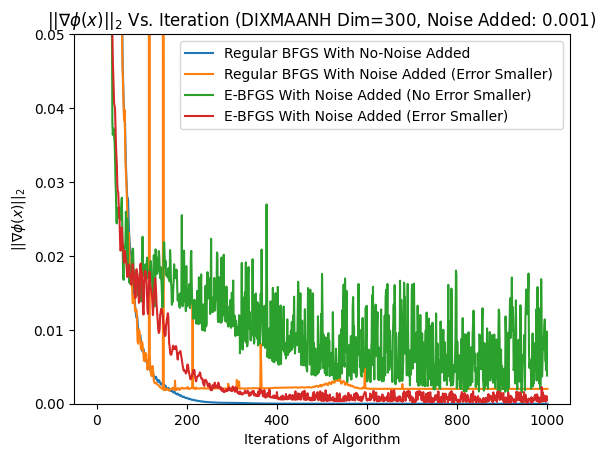

In [41]:
# Plot both lines
plt.plot(range(len(g_class)), g_class, label='Regular BFGS With No-Noise Added ')
plt.plot(range(len(g_class_error1)), g_class_error1, label='Regular BFGS With Noise Added (Error Smaller) ')
plt.plot(range(len(g_ebfgs_error)), g_ebfgs_error, label='E-BFGS With Noise Added (No Error Smaller) ')
plt.plot(range(len(g_ebfgs_error1)), g_ebfgs_error1, label='E-BFGS With Noise Added (Error Smaller) ')
# Add labels and title
plt.title('$||∇\phi (x)||_2$ Vs. Iteration (DIXMAANH Dim=300, Noise Added: $0.001$)')
plt.ylabel('$||∇\phi (x)||_2$')
plt.xlabel('Iterations of Algorithm')
plt.ylim(0,0.05)

# Add legend
plt.legend()
# Show plot
plt.show()

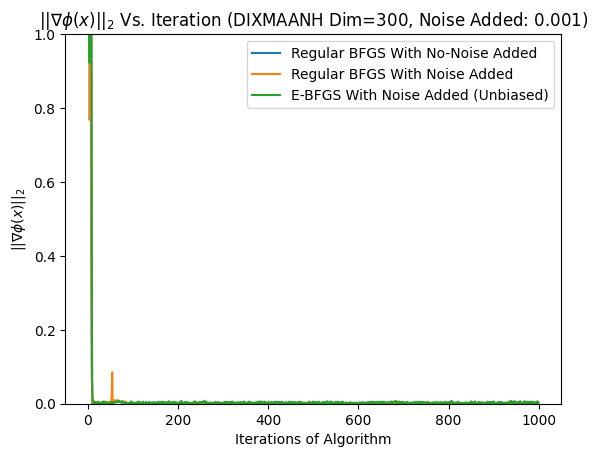

In [12]:
# Plot both lines
plt.plot(range(len(g_class)), g_class, label='Regular BFGS With No-Noise Added')
plt.plot(range(len(g_class_error)), g_class_error, label='Regular BFGS With Noise Added')
plt.plot(range(len(g_ebfgs_error)), g_ebfgs_error, label='E-BFGS With Noise Added (Unbiased)')
# Add labels and title
plt.title('$||∇\phi (x)||_2$ Vs. Iteration (DIXMAANH Dim=300, Noise Added: $0.001$)')
plt.ylabel('$||∇\phi (x)||_2$')
plt.xlabel('Iterations of Algorithm')
plt.ylim(0,1)

# Add legend
plt.legend()
# Show plot
plt.show()

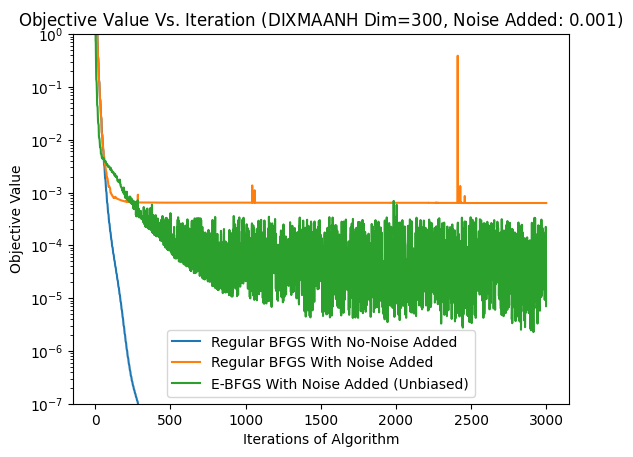

In [34]:
# Plot both lines
plt.plot(range(len(f_class)), f_class-1, label='Regular BFGS With No-Noise Added')
plt.plot(range(len(f_class_error)), f_class_error-1, label='Regular BFGS With Noise Added')
plt.plot(range(len(f_ebfgs_error)), f_ebfgs_error-1, label='E-BFGS With Noise Added (Unbiased)')
# Add labels and title
plt.title('Objective Value Vs. Iteration (DIXMAANH Dim=300, Noise Added: $0.001$)')
plt.ylabel('Objective Value')
plt.xlabel('Iterations of Algorithm')


# Set logarithmic scale for y-axis
plt.yscale('log')
# Set limits for y-axis
plt.ylim(1e-7, 1e0)
# Add legend
plt.legend()
# Show plot
plt.show()

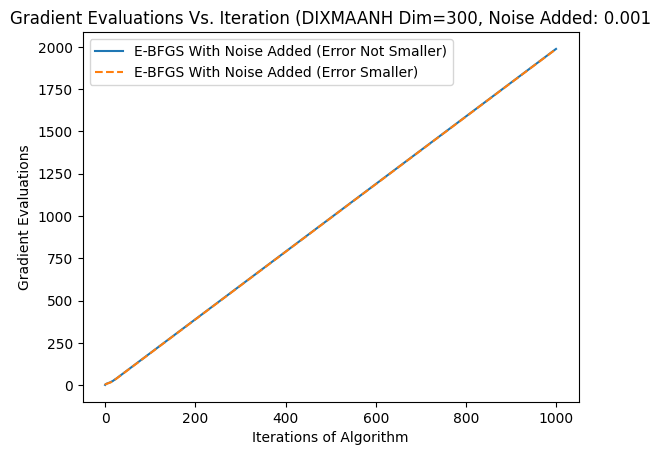

In [47]:
# Plot both lines
plt.plot(range(len(ebfgsgcalls)), ebfgsgcalls, label='E-BFGS With Noise Added (Error Not Smaller)')
#plt.plot(range(len(classgerrorcalls)), classgerrorcalls, label='Regular BFGS With Noise Added')
plt.plot(range(len(ebfgsgcalls1)), ebfgsgcalls1, label='E-BFGS With Noise Added (Error Smaller)', linestyle = '--')
#plt.plot(range(len(spbfgsgcalls)), spbfgsgcalls, label='SP-BFGS With Noise Added (Unbiased)')
# Add labels and title
plt.title("Gradient Evaluations Vs. Iteration (DIXMAANH Dim=300, Noise Added: 0.001")
plt.ylabel('Gradient Evaluations')
plt.xlabel('Iterations of Algorithm')


# Add legend
plt.legend()
# Show plot
plt.show()

In [84]:
#Testing ECNoise
ROSENBR = pycutest.import_problem("DIXMAANH", sifParams={'M':100})
def trueF(ai):
        return ROSENBR.obj(ai)

def trueG(ai):
    _, grad = ROSENBR.obj(ai, gradient=True)
    
    return grad

def fobj(ai):
    return ROSENBR.obj(ai) + np.random.uniform(-0.001, 0.001)

def biasedf(ai):
    return ROSENBR.obj(ai) + np.random.uniform(0, 0.001)
def gobj(ai):
        _, grad = ROSENBR.obj(ai, gradient=True)
        y = np.random.randn(ROSENBR.x0.shape[0])
        Y = y / np.linalg.norm(y)
        U = np.random.rand() ** (1 / ROSENBR.x0.shape[0])
        return grad + (0.001 * U * Y)
ecn = ECNoise(fobj, breadth = 3, max_iter = 10)
ecnbias = ECNoise(biasedf, breadth = 3, max_iter = 10)
noerrorecn = ECNoise(trueF, breadth = 3, max_iter = 10)

In [85]:
total_iter = 10000
sum = 0
for _ in range(total_iter):
    noise, levels, informs,evals = ecn.estimate(ROSENBR.x0)
    sum += noise
print("First X value given by optimization problem with unbiased noise U~(-0.001,0.001):")
print (sum/total_iter)
print('─' * 10)

sum = 0
for _ in range(total_iter):
    noise, levels, informs,evals = ecn.estimate(optError)
    sum += noise
print("Noise at optimal x_k given by E-BFGS with unbiased noise U~(-0.001,0.001):")
print (sum/total_iter)
print('─' * 10)

sum = 0
for _ in range(total_iter):
    noise, levels, informs,evals = ecnbias.estimate(optError)
    sum += noise
print("Noise at optimal x_k given by E-BFGS with biased noise U~(0,0.001):")
print (sum/total_iter)
print('─' * 10)

sum = 0
for _ in range(total_iter):
    noise, levels, informs,evals = noerrorecn.estimate(optError)
    sum += noise
print("Noise at optimal x_k given by E-BFGS with no noise:")
print (sum/total_iter)

First X value given by optimization problem with unbiased noise U~(-0.001,0.001):
0.0005625659536417914
──────────
Noise at optimal x_k given by E-BFGS with unbiased noise U~(-0.001,0.001):
0.0005548720507905872
──────────
Noise at optimal x_k given by E-BFGS with biased noise U~(0,0.001):
0.00027755919613396565
──────────
Noise at optimal x_k given by E-BFGS with no noise:
8.817343249059368e-16


In [94]:
#Testing ECNoise
ROSENBR = pycutest.import_problem("DIXMAANH", sifParams={'M':100})

def trueG(ai):
    _, grad = ROSENBR.obj(ai, gradient=True)
    return np.linalg.norm(grad)

def gobj(ai):
        _, grad = ROSENBR.obj(ai, gradient=True)
        return np.linalg.norm(grad + np.random.uniform(-0.001, 0.001))

def gobjbias(ai):
        _, grad = ROSENBR.obj(ai, gradient=True)
        return np.linalg.norm(grad + np.random.uniform(0, 0.001))

def gobjcircle(ai):
        _, grad = ROSENBR.obj(ai, gradient=True)
        y = np.random.randn(ROSENBR.x0.shape[0])
        Y = y / np.linalg.norm(y)
        U = np.random.rand() ** (1 / ROSENBR.x0.shape[0])
        return np.linalg.norm(grad + (0.001 * U * Y))
    
ecn = ECNoise(gobj, breadth = 3, max_iter = 10)
ecnbias = ECNoise(gobjbias, breadth = 3, max_iter = 10) 
ecnball = ECNoise(gobjcircle, breadth = 3, max_iter = 10) 
noerrorecn = ECNoise(trueG, breadth = 3, max_iter = 10) 

In [97]:
total_iter = 10000
print("Optimal error bound is:" + str(np.sqrt(300)*0.001))
print('─' * 10)
sum = 0
for _ in range(total_iter):
    noise, levels, informs,evals = ecn.estimate(ROSENBR.x0)
    sum += noise
print("First X value given by optimization problem with unbiased noise U~(-0.001,0.001):")
print (sum/total_iter)
print('─' * 10)
sum = 0
for _ in range(total_iter):
    noise, levels, informs,evals = ecnbias.estimate(ROSENBR.x0)
    sum += noise
print("First X value given by optimization problem with Biased noise U~(-0.001,0.001):")
print (sum/total_iter)
print('─' * 10)

sum =0
for _ in range(total_iter):
    noise, levels, informs,evals = ecnball.estimate(ROSENBR.x0)
    sum += noise
print("First X value given by optimization problem with 300-D Ball noise U~(0.001):")
print (sum/total_iter)
print('─' * 10)

sum=0
for _ in range(total_iter):
    noise, levels, informs,evals = noerrorecn.estimate(ROSENBR.x0)
    sum += noise
print("First X value given by optimization problem with no noise:")
print (sum/total_iter)


Optimal error bound is:0.017320508075688777
──────────
First X value given by optimization problem with unbiased noise U~(-0.001,0.001):
0.009589907653688294
──────────
First X value given by optimization problem with Biased noise U~(-0.001,0.001):
0.004774271115790684
──────────
First X value given by optimization problem with 300-D Ball noise U~(0.001):
5.4346074129739596e-05
──────────
First X value given by optimization problem with no noise:
2.342282844747851e-13


### 